# Inception model explanations, t1

## First we need dataframes for every subject

In [1]:
import sys
sys.path.append('../')
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import utils
import keras

%matplotlib inline

# DEFINE GRAPH
from importlib import reload
reload(utils)

pd.set_option('max_colwidth', 800) 

Using TensorFlow backend.


In [3]:
# Data paths
rgb_path = '../data/jpg_320_180_2fps/'
of_path = 'no'

# Hyperparameters
input_width = 320
input_height = 180
seq_length = 10
seq_stride = 1
batch_size = 10
COLOR = True
nb_labels = 2

# Data augmentation
aug_flip = 0
aug_crop = 0
aug_light = 0

nb_input_dims = 4

subject_ids = pd.read_csv('../metadata/horse_subjects.csv')['Subject'].values
channels = 3

In [4]:
from utils import ArgsProxy
args = ArgsProxy(rgb_path, of_path, input_height, input_width,
                 seq_length, seq_stride, batch_size, nb_labels,
                 aug_flip, aug_crop, aug_light, nb_input_dims)

In [5]:
import data_handler as dathand
dh = dathand.DataHandler(path=args.data_path,
                         of_path=args.of_path,
                         clip_list_file='videos_overview_missingremoved.csv',
                         data_columns=['Pain'],  # Here one can append f. ex. 'Observer'
                         image_size=(args.input_height, args.input_width),
                         seq_length=args.seq_length,
                         seq_stride=args.seq_stride,
                         batch_size=args.batch_size,
                         color=COLOR,
                         nb_labels=args.nb_labels,
                         aug_flip=args.aug_flip,
                         aug_crop=args.aug_crop,
                         aug_light=args.aug_light,
                         nb_input_dims=args.nb_input_dims)

In [6]:
import utils
subject_dfs = utils.read_or_create_subject_dfs(dh, args, subject_ids)

../data/jpg_320_180_2fps/
../data/jpg_320_180_2fps/
../data/jpg_320_180_2fps/
../data/jpg_320_180_2fps/
../data/jpg_320_180_2fps/
../data/jpg_320_180_2fps/


## Now that we have frames from all subjects, we can load the model we want to test.

In [10]:
# Choose a model to work on
best_model_path = '../models/BEST_MODEL_inception_4d_input_from_scratch_rmsprop_LSTMunits_None_CONVfilters_None_dense512_320x180jpg2fps_bs100_rmsprop_all_aug_v4_t1_run1_gc_rerun.h5'

In [12]:
from keras import backend as K
import tensorflow as tf

model = keras.models.load_model(best_model_path)

In [34]:
sess = K.get_session()  # Grab the Keras session where the weights are initialized.

print('model preds: ', model.preds)

cost = (-1) * tf.reduce_sum(tf.multiply(labels, tf.log(model.preds)), axis=1)

print('cost: ', cost)

y_c = tf.reduce_sum(tf.multiply(model.dense_2, labels), axis=1)

print('y_c: ', y_c)


# target_conv_layer = model.c_86  # Choose which layer to study
target_conv_layer = model.c_94  # Here: last conv.
# target_conv_layer = model.mixed10 

print('TYPE tcl: ', type(target_conv_layer))
print('tcl: ', target_conv_layer)

target_conv_layer_grad = tf.gradients(y_c, target_conv_layer)[0]

print('tcl grad: ', target_conv_layer_grad)
print('tclg: ', target_conv_layer_grad)
    
gb_grad = tf.gradients(cost, images)[0]  # Guided backpropagation back to input layer

model preds:  Tensor("activation_95_1/Sigmoid:0", shape=(10, 2), dtype=float32)
cost:  Tensor("mul_4:0", shape=(10,), dtype=float32)
y_c:  Tensor("Sum_3:0", shape=(10,), dtype=float32)
TYPE tcl:  <class 'tensorflow.python.framework.ops.Tensor'>
tcl:  Tensor("conv2d_94_1/convolution:0", shape=(10, 8, 4, 192), dtype=float32)
tcl grad:  Tensor("gradients_2/AddN:0", shape=(10, 8, 4, 192), dtype=float32)
tclg:  Tensor("gradients_2/AddN:0", shape=(10, 8, 4, 192), dtype=float32)


In [35]:
def run_on_one_sequence(sess, model, batch_img, args):
    with sess.as_default():
        prob = sess.run(model.preds,
                        feed_dict={images: batch_img,
                                   K.learning_phase(): 0})

        print(prob)
        
        gb_grad_value, target_conv_layer_value, target_conv_layer_grad_value = sess.run([gb_grad, target_conv_layer, target_conv_layer_grad],
              feed_dict={images: batch_img,
              labels: batch_label,
              K.learning_phase(): 0})

#         print('tcl: ')
#         print(target_conv_layer_value)
#         print('')
#         print('tclg: ')
#         print(target_conv_layer_grad_value)
        
        utils.visualize_overlays(batch_img, target_conv_layer_value,
                                 target_conv_layer_grad_value, args)

# Inception predictions for subject 1

Chose subject  1
Start index in subject dataframe:  6174
                                                  Path  Pain
0  data/jpg_320_180_2fps/horse_2/2_2a/frame_002419.jpg     0
1  data/jpg_320_180_2fps/horse_2/2_2a/frame_002420.jpg     0
2  data/jpg_320_180_2fps/horse_2/2_2a/frame_002421.jpg     0
3  data/jpg_320_180_2fps/horse_2/2_2a/frame_002422.jpg     0
4  data/jpg_320_180_2fps/horse_2/2_2a/frame_002423.jpg     0
5  data/jpg_320_180_2fps/horse_2/2_2a/frame_002424.jpg     0
6  data/jpg_320_180_2fps/horse_2/2_2a/frame_002425.jpg     0
7  data/jpg_320_180_2fps/horse_2/2_2a/frame_002426.jpg     0
8  data/jpg_320_180_2fps/horse_2/2_2a/frame_002427.jpg     0
9  data/jpg_320_180_2fps/horse_2/2_2a/frame_002428.jpg     0
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


/Users/sbroome/Documents/EquineML/painface-recognition/notebooks/utils.py:764: RuntimeWarning: invalid value encountered in true_divide
  for i, w in enumerate(weights):
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/matplotli

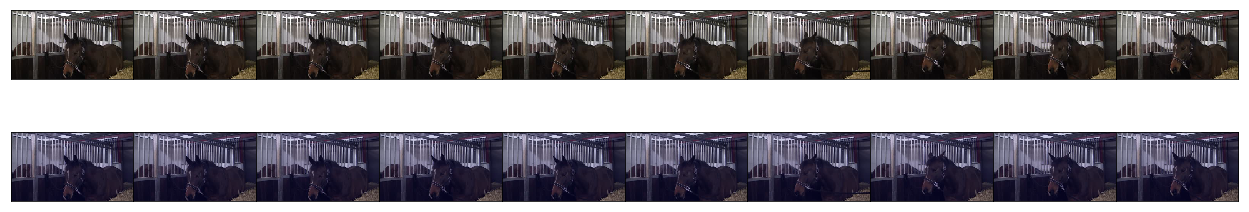

In [36]:
batch_img, batch_label = utils.data_for_one_random_sequence_4D(args, subject_dfs, computer='local', subject=1)
batch_img = np.array(batch_img, dtype=np.float32)

batch_label = np.array(batch_label, dtype=np.uint8)
run_on_one_sequence(sess, model, batch_img, args)

Chose subject  1
Start index in subject dataframe:  8980
                                                    Path  Pain
0  data/jpg_320_180_2fps/horse_2/2_3a_1/frame_001603.jpg     1
1  data/jpg_320_180_2fps/horse_2/2_3a_1/frame_001604.jpg     1
2  data/jpg_320_180_2fps/horse_2/2_3a_1/frame_001605.jpg     1
3  data/jpg_320_180_2fps/horse_2/2_3a_1/frame_001606.jpg     1
4  data/jpg_320_180_2fps/horse_2/2_3a_1/frame_001607.jpg     1
5  data/jpg_320_180_2fps/horse_2/2_3a_1/frame_001608.jpg     1
6  data/jpg_320_180_2fps/horse_2/2_3a_1/frame_001609.jpg     1
7  data/jpg_320_180_2fps/horse_2/2_3a_1/frame_001610.jpg     1
8  data/jpg_320_180_2fps/horse_2/2_3a_1/frame_001611.jpg     1
9  data/jpg_320_180_2fps/horse_2/2_3a_1/frame_001612.jpg     1
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


/Users/sbroome/Documents/EquineML/painface-recognition/notebooks/utils.py:764: RuntimeWarning: invalid value encountered in true_divide
  for i, w in enumerate(weights):
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/matplotli

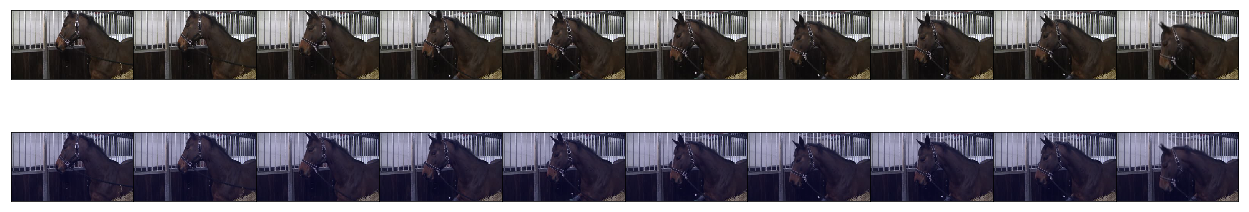

In [37]:
batch_img, batch_label = utils.data_for_one_random_sequence_4D(args, subject_dfs, computer='local', subject=1)
batch_img = np.array(batch_img, dtype=np.float32)

batch_label = np.array(batch_label, dtype=np.uint8)
run_on_one_sequence(sess, model, batch_img, args)

Chose subject  1
Start index in subject dataframe:  434
                                                  Path  Pain
0  data/jpg_320_180_2fps/horse_2/2_1a/frame_000435.jpg     0
1  data/jpg_320_180_2fps/horse_2/2_1a/frame_000436.jpg     0
2  data/jpg_320_180_2fps/horse_2/2_1a/frame_000437.jpg     0
3  data/jpg_320_180_2fps/horse_2/2_1a/frame_000438.jpg     0
4  data/jpg_320_180_2fps/horse_2/2_1a/frame_000439.jpg     0
5  data/jpg_320_180_2fps/horse_2/2_1a/frame_000440.jpg     0
6  data/jpg_320_180_2fps/horse_2/2_1a/frame_000441.jpg     0
7  data/jpg_320_180_2fps/horse_2/2_1a/frame_000442.jpg     0
8  data/jpg_320_180_2fps/horse_2/2_1a/frame_000443.jpg     0
9  data/jpg_320_180_2fps/horse_2/2_1a/frame_000444.jpg     0
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/sbroome/Documents/EquineML/painface-recognition/notebooks/utils.py:764: RuntimeWarning: invalid value encountered in true_divide
  for i, w in enumerate(weights):
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/matplotli

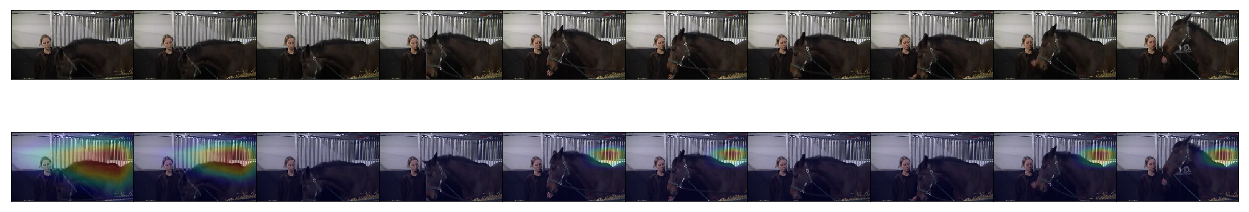

In [38]:
batch_img, batch_label = utils.data_for_one_random_sequence_4D(args, subject_dfs, computer='local', subject=1)
batch_img = np.array(batch_img, dtype=np.float32)

batch_label = np.array(batch_label, dtype=np.uint8)
run_on_one_sequence(sess, model, batch_img, args)

Chose subject  1
Start index in subject dataframe:  11837
                                                 Path  Pain
0  data/jpg_320_180_2fps/horse_2/2_4/frame_001160.jpg     1
1  data/jpg_320_180_2fps/horse_2/2_4/frame_001161.jpg     1
2  data/jpg_320_180_2fps/horse_2/2_4/frame_001162.jpg     1
3  data/jpg_320_180_2fps/horse_2/2_4/frame_001163.jpg     1
4  data/jpg_320_180_2fps/horse_2/2_4/frame_001164.jpg     1
5  data/jpg_320_180_2fps/horse_2/2_4/frame_001165.jpg     1
6  data/jpg_320_180_2fps/horse_2/2_4/frame_001166.jpg     1
7  data/jpg_320_180_2fps/horse_2/2_4/frame_001167.jpg     1
8  data/jpg_320_180_2fps/horse_2/2_4/frame_001168.jpg     1
9  data/jpg_320_180_2fps/horse_2/2_4/frame_001169.jpg     1
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


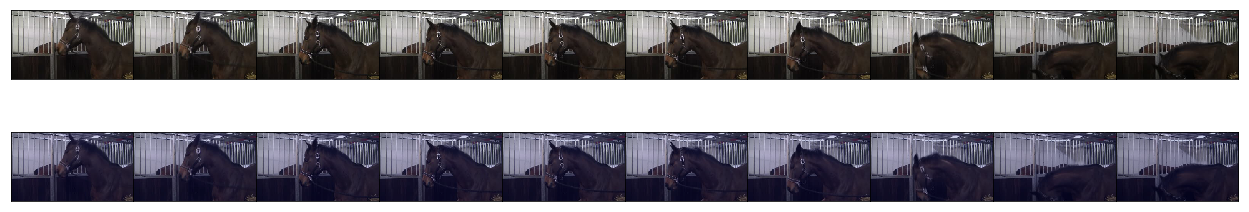

In [41]:
batch_img, batch_label = utils.data_for_one_random_sequence_4D(args, subject_dfs, computer='local', subject=1)
batch_img = np.array(batch_img, dtype=np.float32)

batch_label = np.array(batch_label, dtype=np.uint8)
run_on_one_sequence(sess, model, batch_img, args)

Chose subject  1
Start index in subject dataframe:  10174
                                                    Path  Pain
0  data/jpg_320_180_2fps/horse_2/2_3a_2/frame_001117.jpg     1
1  data/jpg_320_180_2fps/horse_2/2_3a_2/frame_001118.jpg     1
2  data/jpg_320_180_2fps/horse_2/2_3a_2/frame_001119.jpg     1
3  data/jpg_320_180_2fps/horse_2/2_3a_2/frame_001120.jpg     1
4  data/jpg_320_180_2fps/horse_2/2_3a_2/frame_001121.jpg     1
5  data/jpg_320_180_2fps/horse_2/2_3a_2/frame_001122.jpg     1
6  data/jpg_320_180_2fps/horse_2/2_3a_2/frame_001123.jpg     1
7  data/jpg_320_180_2fps/horse_2/2_3a_2/frame_001124.jpg     1
8  data/jpg_320_180_2fps/horse_2/2_3a_2/frame_001125.jpg     1
9  data/jpg_320_180_2fps/horse_2/2_3a_2/frame_001126.jpg     1
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


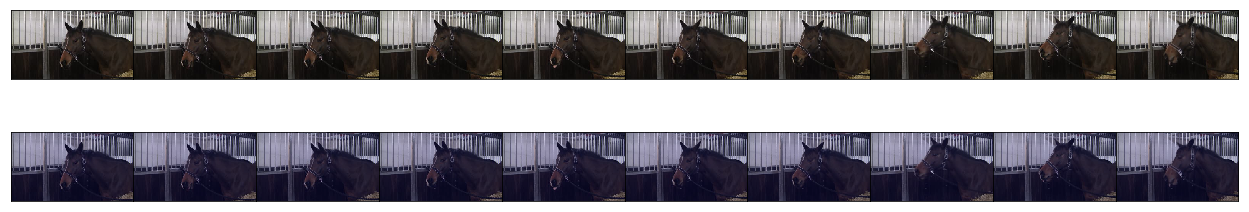

In [42]:
batch_img, batch_label = utils.data_for_one_random_sequence_4D(args, subject_dfs, computer='local', subject=1)
batch_img = np.array(batch_img, dtype=np.float32)

batch_label = np.array(batch_label, dtype=np.uint8)
run_on_one_sequence(sess, model, batch_img, args)

Chose subject  1
Start index in subject dataframe:  4514
                                                  Path  Pain
0  data/jpg_320_180_2fps/horse_2/2_2a/frame_000759.jpg     0
1  data/jpg_320_180_2fps/horse_2/2_2a/frame_000760.jpg     0
2  data/jpg_320_180_2fps/horse_2/2_2a/frame_000761.jpg     0
3  data/jpg_320_180_2fps/horse_2/2_2a/frame_000762.jpg     0
4  data/jpg_320_180_2fps/horse_2/2_2a/frame_000763.jpg     0
5  data/jpg_320_180_2fps/horse_2/2_2a/frame_000764.jpg     0
6  data/jpg_320_180_2fps/horse_2/2_2a/frame_000765.jpg     0
7  data/jpg_320_180_2fps/horse_2/2_2a/frame_000766.jpg     0
8  data/jpg_320_180_2fps/horse_2/2_2a/frame_000767.jpg     0
9  data/jpg_320_180_2fps/horse_2/2_2a/frame_000768.jpg     0
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


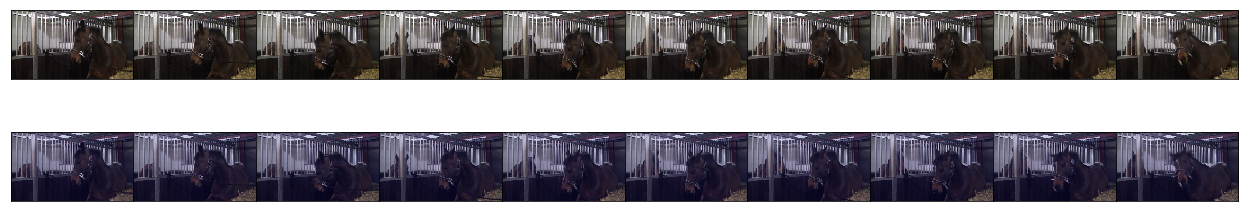

In [43]:
batch_img, batch_label = utils.data_for_one_random_sequence_4D(args, subject_dfs, computer='local', subject=1)
batch_img = np.array(batch_img, dtype=np.float32)

batch_label = np.array(batch_label, dtype=np.uint8)
run_on_one_sequence(sess, model, batch_img, args)

Chose subject  1
Start index in subject dataframe:  5387
                                                  Path  Pain
0  data/jpg_320_180_2fps/horse_2/2_2a/frame_001632.jpg     0
1  data/jpg_320_180_2fps/horse_2/2_2a/frame_001633.jpg     0
2  data/jpg_320_180_2fps/horse_2/2_2a/frame_001634.jpg     0
3  data/jpg_320_180_2fps/horse_2/2_2a/frame_001635.jpg     0
4  data/jpg_320_180_2fps/horse_2/2_2a/frame_001636.jpg     0
5  data/jpg_320_180_2fps/horse_2/2_2a/frame_001637.jpg     0
6  data/jpg_320_180_2fps/horse_2/2_2a/frame_001638.jpg     0
7  data/jpg_320_180_2fps/horse_2/2_2a/frame_001639.jpg     0
8  data/jpg_320_180_2fps/horse_2/2_2a/frame_001640.jpg     0
9  data/jpg_320_180_2fps/horse_2/2_2a/frame_001641.jpg     0
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


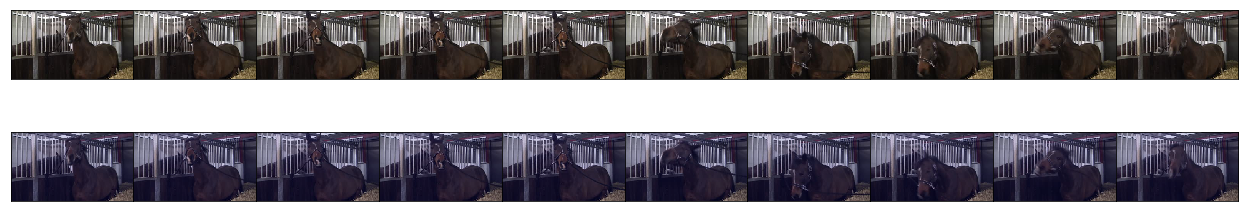

In [44]:
batch_img, batch_label = utils.data_for_one_random_sequence_4D(args, subject_dfs, computer='local', subject=1)
batch_img = np.array(batch_img, dtype=np.float32)

batch_label = np.array(batch_label, dtype=np.uint8)
run_on_one_sequence(sess, model, batch_img, args)

Chose subject  1
Start index in subject dataframe:  11664
                                                 Path  Pain
0  data/jpg_320_180_2fps/horse_2/2_4/frame_000987.jpg     1
1  data/jpg_320_180_2fps/horse_2/2_4/frame_000988.jpg     1
2  data/jpg_320_180_2fps/horse_2/2_4/frame_000989.jpg     1
3  data/jpg_320_180_2fps/horse_2/2_4/frame_000990.jpg     1
4  data/jpg_320_180_2fps/horse_2/2_4/frame_000991.jpg     1
5  data/jpg_320_180_2fps/horse_2/2_4/frame_000992.jpg     1
6  data/jpg_320_180_2fps/horse_2/2_4/frame_000993.jpg     1
7  data/jpg_320_180_2fps/horse_2/2_4/frame_000994.jpg     1
8  data/jpg_320_180_2fps/horse_2/2_4/frame_000995.jpg     1
9  data/jpg_320_180_2fps/horse_2/2_4/frame_000996.jpg     1
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


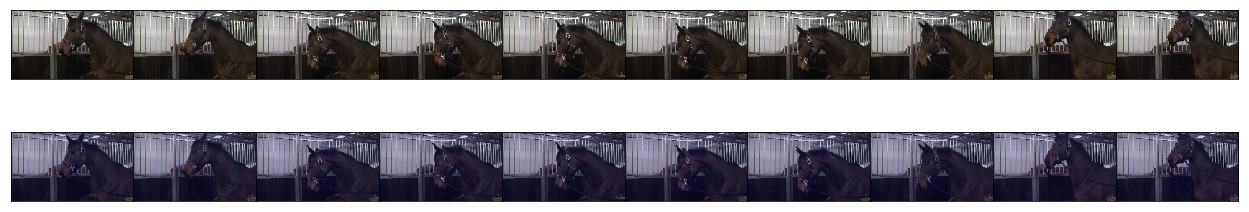

In [45]:
batch_img, batch_label = utils.data_for_one_random_sequence_4D(args, subject_dfs, computer='local', subject=1)
batch_img = np.array(batch_img, dtype=np.float32)

batch_label = np.array(batch_label, dtype=np.uint8)
run_on_one_sequence(sess, model, batch_img, args)

Chose subject  1
Start index in subject dataframe:  6984
                                                  Path  Pain
0  data/jpg_320_180_2fps/horse_2/2_2b/frame_000565.jpg     0
1  data/jpg_320_180_2fps/horse_2/2_2b/frame_000566.jpg     0
2  data/jpg_320_180_2fps/horse_2/2_2b/frame_000567.jpg     0
3  data/jpg_320_180_2fps/horse_2/2_2b/frame_000568.jpg     0
4  data/jpg_320_180_2fps/horse_2/2_2b/frame_000569.jpg     0
5  data/jpg_320_180_2fps/horse_2/2_2b/frame_000570.jpg     0
6  data/jpg_320_180_2fps/horse_2/2_2b/frame_000571.jpg     0
7  data/jpg_320_180_2fps/horse_2/2_2b/frame_000572.jpg     0
8  data/jpg_320_180_2fps/horse_2/2_2b/frame_000573.jpg     0
9  data/jpg_320_180_2fps/horse_2/2_2b/frame_000574.jpg     0
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


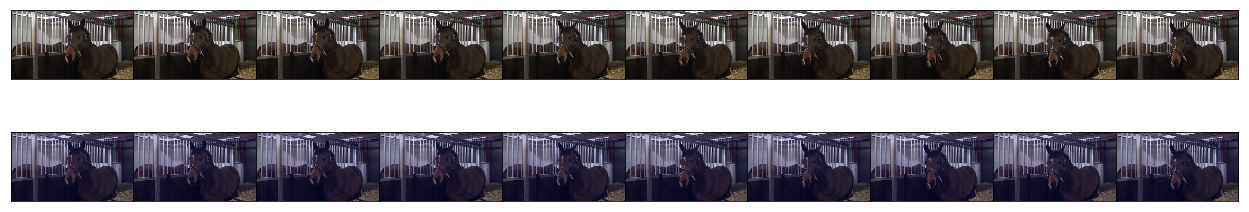

In [46]:
batch_img, batch_label = utils.data_for_one_random_sequence_4D(args, subject_dfs, computer='local', subject=1)
batch_img = np.array(batch_img, dtype=np.float32)

batch_label = np.array(batch_label, dtype=np.uint8)
run_on_one_sequence(sess, model, batch_img, args)

Chose subject  1
Start index in subject dataframe:  7896
                                                    Path  Pain
0  data/jpg_320_180_2fps/horse_2/2_3a_1/frame_000519.jpg     1
1  data/jpg_320_180_2fps/horse_2/2_3a_1/frame_000520.jpg     1
2  data/jpg_320_180_2fps/horse_2/2_3a_1/frame_000521.jpg     1
3  data/jpg_320_180_2fps/horse_2/2_3a_1/frame_000522.jpg     1
4  data/jpg_320_180_2fps/horse_2/2_3a_1/frame_000523.jpg     1
5  data/jpg_320_180_2fps/horse_2/2_3a_1/frame_000524.jpg     1
6  data/jpg_320_180_2fps/horse_2/2_3a_1/frame_000525.jpg     1
7  data/jpg_320_180_2fps/horse_2/2_3a_1/frame_000526.jpg     1
8  data/jpg_320_180_2fps/horse_2/2_3a_1/frame_000527.jpg     1
9  data/jpg_320_180_2fps/horse_2/2_3a_1/frame_000528.jpg     1
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


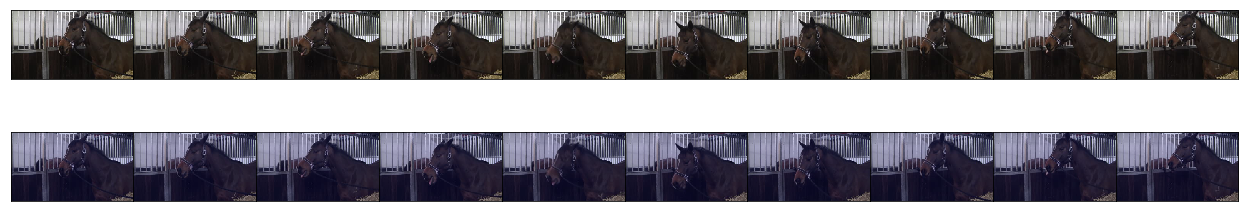

In [54]:
batch_img, batch_label = utils.data_for_one_random_sequence_4D(args, subject_dfs, computer='local', subject=1)
batch_img = np.array(batch_img, dtype=np.float32)

batch_label = np.array(batch_label, dtype=np.uint8)
run_on_one_sequence(sess, model, batch_img, args)

Chose subject  1
Start index in subject dataframe:  9340
                                                    Path  Pain
0  data/jpg_320_180_2fps/horse_2/2_3a_2/frame_000283.jpg     1
1  data/jpg_320_180_2fps/horse_2/2_3a_2/frame_000284.jpg     1
2  data/jpg_320_180_2fps/horse_2/2_3a_2/frame_000285.jpg     1
3  data/jpg_320_180_2fps/horse_2/2_3a_2/frame_000286.jpg     1
4  data/jpg_320_180_2fps/horse_2/2_3a_2/frame_000287.jpg     1
5  data/jpg_320_180_2fps/horse_2/2_3a_2/frame_000288.jpg     1
6  data/jpg_320_180_2fps/horse_2/2_3a_2/frame_000289.jpg     1
7  data/jpg_320_180_2fps/horse_2/2_3a_2/frame_000290.jpg     1
8  data/jpg_320_180_2fps/horse_2/2_3a_2/frame_000291.jpg     1
9  data/jpg_320_180_2fps/horse_2/2_3a_2/frame_000292.jpg     1
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


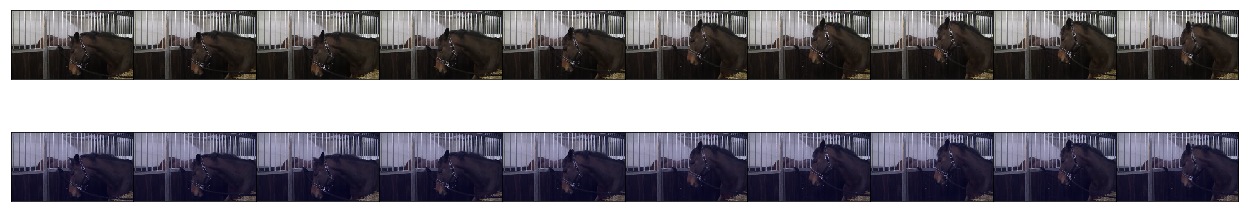

In [47]:
batch_img, batch_label = utils.data_for_one_random_sequence_4D(args, subject_dfs, computer='local', subject=1)
batch_img = np.array(batch_img, dtype=np.float32)

batch_label = np.array(batch_label, dtype=np.uint8)
run_on_one_sequence(sess, model, batch_img, args)

Chose subject  1
Start index in subject dataframe:  8248
                                                    Path  Pain
0  data/jpg_320_180_2fps/horse_2/2_3a_1/frame_000871.jpg     1
1  data/jpg_320_180_2fps/horse_2/2_3a_1/frame_000872.jpg     1
2  data/jpg_320_180_2fps/horse_2/2_3a_1/frame_000873.jpg     1
3  data/jpg_320_180_2fps/horse_2/2_3a_1/frame_000874.jpg     1
4  data/jpg_320_180_2fps/horse_2/2_3a_1/frame_000875.jpg     1
5  data/jpg_320_180_2fps/horse_2/2_3a_1/frame_000876.jpg     1
6  data/jpg_320_180_2fps/horse_2/2_3a_1/frame_000877.jpg     1
7  data/jpg_320_180_2fps/horse_2/2_3a_1/frame_000878.jpg     1
8  data/jpg_320_180_2fps/horse_2/2_3a_1/frame_000879.jpg     1
9  data/jpg_320_180_2fps/horse_2/2_3a_1/frame_000880.jpg     1
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


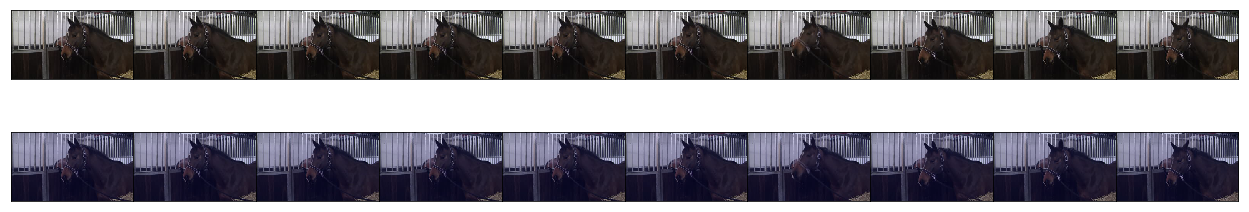

In [53]:
batch_img, batch_label = utils.data_for_one_random_sequence_4D(args, subject_dfs, computer='local', subject=1)
batch_img = np.array(batch_img, dtype=np.float32)

batch_label = np.array(batch_label, dtype=np.uint8)
run_on_one_sequence(sess, model, batch_img, args)

Chose subject  0
Start index in subject dataframe:  2681
                                                  Path  Pain
0  data/jpg_320_180_2fps/horse_1/1_1b/frame_000010.jpg     0
1  data/jpg_320_180_2fps/horse_1/1_1b/frame_000011.jpg     0
2  data/jpg_320_180_2fps/horse_1/1_1b/frame_000012.jpg     0
3  data/jpg_320_180_2fps/horse_1/1_1b/frame_000013.jpg     0
4  data/jpg_320_180_2fps/horse_1/1_1b/frame_000014.jpg     0
5  data/jpg_320_180_2fps/horse_1/1_1b/frame_000015.jpg     0
6  data/jpg_320_180_2fps/horse_1/1_1b/frame_000016.jpg     0
7  data/jpg_320_180_2fps/horse_1/1_1b/frame_000017.jpg     0
8  data/jpg_320_180_2fps/horse_1/1_1b/frame_000018.jpg     0
9  data/jpg_320_180_2fps/horse_1/1_1b/frame_000019.jpg     0
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


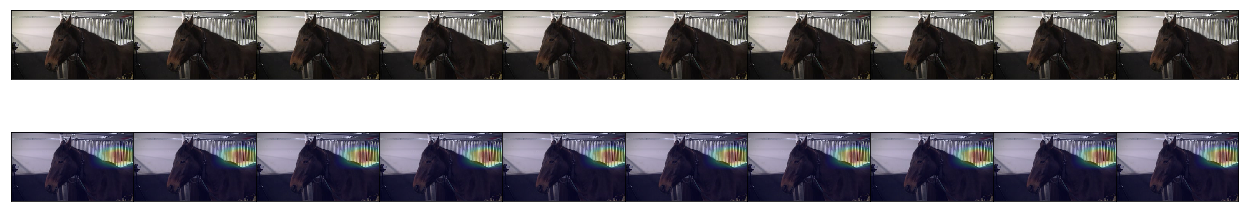

In [48]:
batch_img, batch_label = utils.data_for_one_random_sequence_4D(args, subject_dfs, computer='local', subject=0)
batch_img = np.array(batch_img, dtype=np.float32)

batch_label = np.array(batch_label, dtype=np.uint8)
run_on_one_sequence(sess, model, batch_img, args)

Chose subject  2
Start index in subject dataframe:  7342
                                                  Path  Pain
0  data/jpg_320_180_2fps/horse_3/3_3a/frame_000003.jpg     1
1  data/jpg_320_180_2fps/horse_3/3_3a/frame_000004.jpg     1
2  data/jpg_320_180_2fps/horse_3/3_3a/frame_000005.jpg     1
3  data/jpg_320_180_2fps/horse_3/3_3a/frame_000006.jpg     1
4  data/jpg_320_180_2fps/horse_3/3_3a/frame_000007.jpg     1
5  data/jpg_320_180_2fps/horse_3/3_3a/frame_000008.jpg     1
6  data/jpg_320_180_2fps/horse_3/3_3a/frame_000009.jpg     1
7  data/jpg_320_180_2fps/horse_3/3_3a/frame_000010.jpg     1
8  data/jpg_320_180_2fps/horse_3/3_3a/frame_000011.jpg     1
9  data/jpg_320_180_2fps/horse_3/3_3a/frame_000012.jpg     1
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


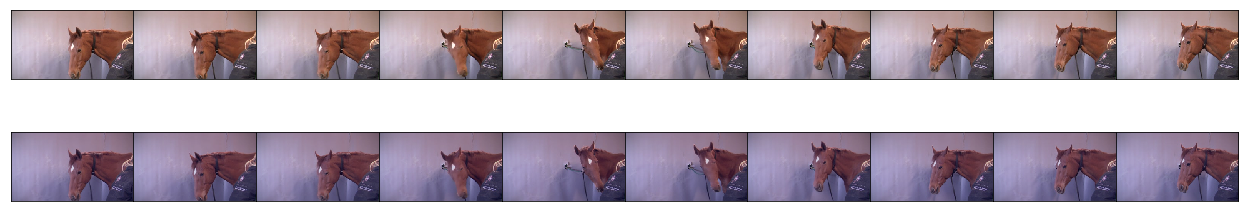

In [52]:
batch_img, batch_label = utils.data_for_one_random_sequence_4D(args, subject_dfs, computer='local', subject=2)
batch_img = np.array(batch_img, dtype=np.float32)

batch_label = np.array(batch_label, dtype=np.uint8)
run_on_one_sequence(sess, model, batch_img, args)

Chose subject  3
Start index in subject dataframe:  8498
                                                  Path  Pain
0  data/jpg_320_180_2fps/horse_4/4_2a/frame_001203.jpg     0
1  data/jpg_320_180_2fps/horse_4/4_2a/frame_001204.jpg     0
2  data/jpg_320_180_2fps/horse_4/4_2a/frame_001205.jpg     0
3  data/jpg_320_180_2fps/horse_4/4_2a/frame_001206.jpg     0
4  data/jpg_320_180_2fps/horse_4/4_2a/frame_001207.jpg     0
5  data/jpg_320_180_2fps/horse_4/4_2a/frame_001208.jpg     0
6  data/jpg_320_180_2fps/horse_4/4_2a/frame_001209.jpg     0
7  data/jpg_320_180_2fps/horse_4/4_2a/frame_001210.jpg     0
8  data/jpg_320_180_2fps/horse_4/4_2a/frame_001211.jpg     0
9  data/jpg_320_180_2fps/horse_4/4_2a/frame_001212.jpg     0
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


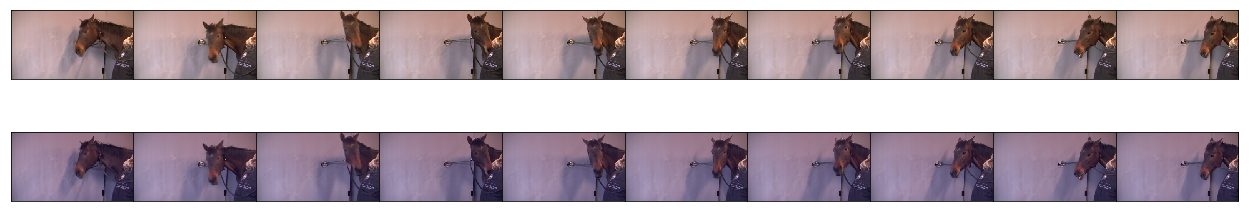

In [49]:
batch_img, batch_label = utils.data_for_one_random_sequence_4D(args, subject_dfs, computer='local', subject=3)
batch_img = np.array(batch_img, dtype=np.float32)

batch_label = np.array(batch_label, dtype=np.uint8)
run_on_one_sequence(sess, model, batch_img, args)

Chose subject  4
Start index in subject dataframe:  9071
                                                  Path  Pain
0  data/jpg_320_180_2fps/horse_5/5_4a/frame_001294.jpg     1
1  data/jpg_320_180_2fps/horse_5/5_4a/frame_001295.jpg     1
2  data/jpg_320_180_2fps/horse_5/5_4a/frame_001296.jpg     1
3  data/jpg_320_180_2fps/horse_5/5_4a/frame_001297.jpg     1
4  data/jpg_320_180_2fps/horse_5/5_4a/frame_001298.jpg     1
5  data/jpg_320_180_2fps/horse_5/5_4a/frame_001299.jpg     1
6  data/jpg_320_180_2fps/horse_5/5_4a/frame_001300.jpg     1
7  data/jpg_320_180_2fps/horse_5/5_4a/frame_001301.jpg     1
8  data/jpg_320_180_2fps/horse_5/5_4a/frame_001302.jpg     1
9  data/jpg_320_180_2fps/horse_5/5_4a/frame_001303.jpg     1
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


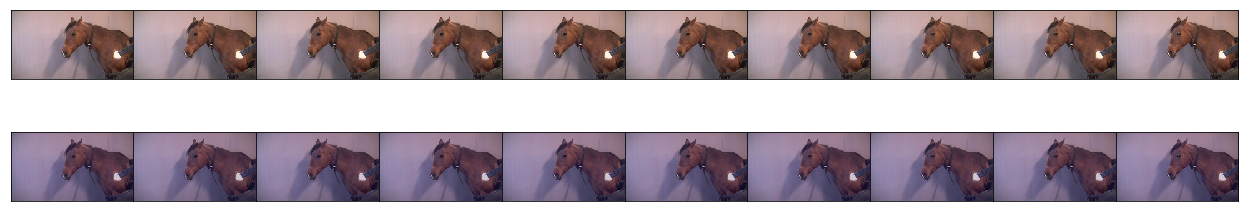

In [51]:
batch_img, batch_label = utils.data_for_one_random_sequence_4D(args, subject_dfs, computer='local', subject=4)
batch_img = np.array(batch_img, dtype=np.float32)

batch_label = np.array(batch_label, dtype=np.uint8)
run_on_one_sequence(sess, model, batch_img, args)

Chose subject  5
Start index in subject dataframe:  1119
                                                  Path  Pain
0  data/jpg_320_180_2fps/horse_6/6_2a/frame_001120.jpg     0
1  data/jpg_320_180_2fps/horse_6/6_2a/frame_001121.jpg     0
2  data/jpg_320_180_2fps/horse_6/6_2a/frame_001122.jpg     0
3  data/jpg_320_180_2fps/horse_6/6_2a/frame_001123.jpg     0
4  data/jpg_320_180_2fps/horse_6/6_2a/frame_001124.jpg     0
5  data/jpg_320_180_2fps/horse_6/6_2a/frame_001125.jpg     0
6  data/jpg_320_180_2fps/horse_6/6_2a/frame_001126.jpg     0
7  data/jpg_320_180_2fps/horse_6/6_2a/frame_001127.jpg     0
8  data/jpg_320_180_2fps/horse_6/6_2a/frame_001128.jpg     0
9  data/jpg_320_180_2fps/horse_6/6_2a/frame_001129.jpg     0
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


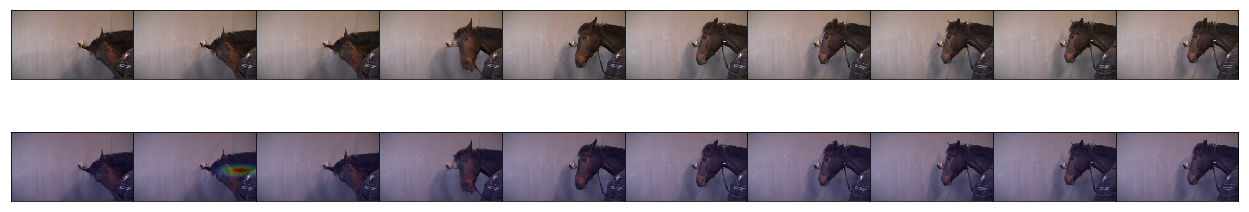

In [50]:
batch_img, batch_label = utils.data_for_one_random_sequence_4D(args, subject_dfs, computer='local', subject=5)
batch_img = np.array(batch_img, dtype=np.float32)

batch_label = np.array(batch_label, dtype=np.uint8)
run_on_one_sequence(sess, model, batch_img, args)

Chose subject  1
Start index in subject dataframe:  1049
                                                  Path  Pain
0  data/jpg_320_180_2fps/horse_2/2_1a/frame_001050.jpg     0
1  data/jpg_320_180_2fps/horse_2/2_1a/frame_001051.jpg     0
2  data/jpg_320_180_2fps/horse_2/2_1a/frame_001052.jpg     0
3  data/jpg_320_180_2fps/horse_2/2_1a/frame_001053.jpg     0
4  data/jpg_320_180_2fps/horse_2/2_1a/frame_001054.jpg     0
5  data/jpg_320_180_2fps/horse_2/2_1a/frame_001055.jpg     0
6  data/jpg_320_180_2fps/horse_2/2_1a/frame_001056.jpg     0
7  data/jpg_320_180_2fps/horse_2/2_1a/frame_001057.jpg     0
8  data/jpg_320_180_2fps/horse_2/2_1a/frame_001058.jpg     0
9  data/jpg_320_180_2fps/horse_2/2_1a/frame_001059.jpg     0
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


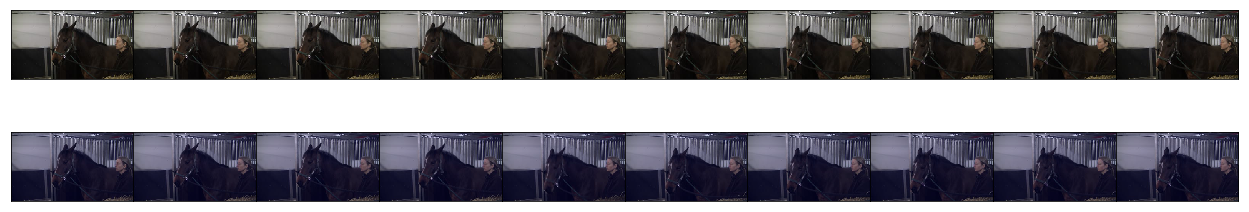

In [55]:
batch_img, batch_label = utils.data_for_one_random_sequence_4D(args, subject_dfs, computer='local', subject=1)
batch_img = np.array(batch_img, dtype=np.float32)

batch_label = np.array(batch_label, dtype=np.uint8)
run_on_one_sequence(sess, model, batch_img, args)

Chose subject  5
Start index in subject dataframe:  2872
                                                  Path  Pain
0  data/jpg_320_180_2fps/horse_6/6_2b/frame_000873.jpg     0
1  data/jpg_320_180_2fps/horse_6/6_2b/frame_000874.jpg     0
2  data/jpg_320_180_2fps/horse_6/6_2b/frame_000875.jpg     0
3  data/jpg_320_180_2fps/horse_6/6_2b/frame_000876.jpg     0
4  data/jpg_320_180_2fps/horse_6/6_2b/frame_000877.jpg     0
5  data/jpg_320_180_2fps/horse_6/6_2b/frame_000878.jpg     0
6  data/jpg_320_180_2fps/horse_6/6_2b/frame_000879.jpg     0
7  data/jpg_320_180_2fps/horse_6/6_2b/frame_000880.jpg     0
8  data/jpg_320_180_2fps/horse_6/6_2b/frame_000881.jpg     0
9  data/jpg_320_180_2fps/horse_6/6_2b/frame_000882.jpg     0
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


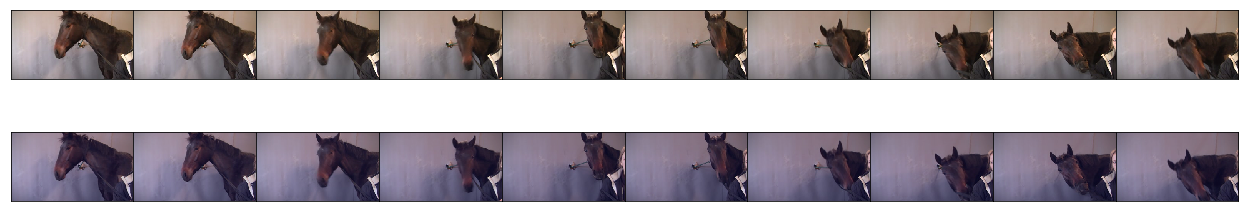

In [56]:
batch_img, batch_label = utils.data_for_one_random_sequence_4D(args, subject_dfs, computer='local', subject=5)
batch_img = np.array(batch_img, dtype=np.float32)

batch_label = np.array(batch_label, dtype=np.uint8)
run_on_one_sequence(sess, model, batch_img, args)